## **Setup**

In [1]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten, Bidirectional, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed

In [4]:
# from google.colab import drive
# mount_path = '/content/gdrive/'
# drive.mount(mount_path)

In [5]:
# Set and test path to competition data files
competition_path = '/home/praneet/Downloads/Compressed/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**

All functions will be used in the "Training the Model" section.

### **Data loading**

In [6]:
# Functions for loading the data
def load_data(file_path):
  """
  Reads all data files (metadata and signal matrix data) as python dictionary,
  the pkl and csv files must have the same file name.

  Arguments:
    file_path -- {str} -- path to the iq_matrix file and metadata file

  Returns:
    Python dictionary
  """
  pkl = load_pkl_data(file_path)
  meta = load_csv_metadata(file_path)
  data_dictionary = {**meta, **pkl}
  
  for key in data_dictionary.keys():
    data_dictionary[key] = np.array(data_dictionary[key])

  return data_dictionary


def load_pkl_data(file_path):
  """
  Reads pickle file as a python dictionary (only Signal data).

  Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

  Returns:
    Python dictionary
  """
  path = os.path.join(competition_path, file_path + '.pkl')
  with open(path, 'rb') as data:
    output = pickle.load(data)
  return output


def load_csv_metadata(file_path):
  """
  Reads csv as pandas DataFrame (only Metadata).

  Arguments:
    file_path -- {str} -- path to csv metadata file

  Returns:
    Pandas DataFarme
  """
  path = os.path.join(competition_path, file_path + '.csv')
  with open(path, 'rb') as data:
    output = pd.read_csv(data)
  return output

## **Data Preprocessing**
**The preprocessing main steps:**   
1. Applying [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (Discrete Fourier transform) by using the fast Fourier transform algorithm ([FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) and [Hann function](https://www.mathworks.com/help/signal/ref/hann.html) to smooth the I/Q matrix. Afterward, calculating the absolute value of the I/Q matrix complex numbers.   
More information about Windowing and Hann function:   
[Wikipedia Hann](https://en.wikipedia.org/wiki/Hann_function#:~:text=The%20Hann%20function%20of%20length,can%20be%20even%20or%20odd.)   
[Wikipedia Window function](https://en.wikipedia.org/wiki/Window_function)   
2. Set max value on the center of the target's mass.   
The doppler burst is a vector (1 x 32) that marks the center of the target's mass on each I/Q matrix in every time unit (32 time-units).   
The preprocess sets the maximum value of each I/Q matrix in-place of the values at the center of the target's mass.
3. Normalization - Transforming I/Q matrix values to standardized values.   
Subtraction of the mean and division by the standard deviation.

**Preprocessing main steps explained:**   
The DFT converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa.   
The I/Q matrix in this challenge is being converted from the velocity domain to the frequency domain.
Windows (like "Hann") are used to reduce spectral leakage when performing a Fourier Transform on time data and converting it into the frequency domain.

The purpose of switching the values of the center of the target's mass in the I/Q matrix with the max value of the matrix is to enhance this part of the matrix and focus the model on this part.


Finally, the normalization is used for scaling all the I/Q matrices.

* *Note: the target_type lables are strings ("human" and "animal"), the data_preprocess function replaces them to "human" = 1 and "animal" = 0.*   
   


**The FFT Process Explained:**   
The IQ matrix contains 32 x 128 elements being 128 I/Q time data samples within a single radar processing time frame and 32 consecutive such time units. The X-axis represents the pulse transmission time, also known as “slow-time”. The Y-axis represents the reception time of signals with respect to pulse transmission time divided into 128 equal sized bins, also known as “fast-time”. The reason FFT is performed on the ‘fast time’ axis (i.e. 128 samples) rather than on the ‘slow time’ axis (i.e. 32 samples) is a matter of scale. An underlying assumption for an effective FFT analysis is that ‘acceleration’ during the time frame represented by the data is very low. Given the type of motion presented by humans and animals only the ‘fast time’ axis complies with this assumption.
Therefore, FFT processing should be applied over the dimension of 128 I/Q time samples to get the frequency content of the returned radar signal at each time frame. A spectrogram (as shown in the samples) is generated by attaching together 32 consecutive FFT results (please note that besides FFT processing some additional manipulation is required to properly display a spectrogram – like taking a LOG of the absolute value and passing a threshold – this is well detailed in the ‘Processing’ section of the competition notebook). Therefore, a spectrogram would eventually provide a display of how the frequency content of the returned signal is changing along time.

In [171]:
# Functions for preprocessing and preprocess function
def fft(iq, axis=0):
  """
  Computes the log of discrete Fourier Transform (DFT).
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform fft in (Default = 0)

  Returns:
    log of DFT on iq_burst array
  """
  iq = np.log(np.abs(np.fft.fft(hann(iq), axis=axis)))
  return iq


def hann(iq, window=None):
    """
    Preformes Hann smoothing of 'iq_sweep_burst'.

    Arguments:
      iq {ndarray} -- 'iq_sweep_burst' array
      window -{range} -- range of hann window indices (Default=None)
               if None the whole column is taken

    Returns:
      Regulazied iq in shape - (window[1] - window[0] - 2, iq.shape[1])
    """
    if window is None:
        window = [0, len(iq)]

    N = window[1] - window[0] - 1
    n = np.arange(window[0], window[1])
    n = n.reshape(len(n), 1)
    hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
    return (hannCol * iq[window[0]:window[1]])[1:-1]


def max_value_on_doppler(iq, doppler_burst):
  """
  Set max value on I/Q matrix using doppler burst vector. 
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
               
  Returns:
    I/Q matrix with the max value instead of the original values
    The doppler burst marks the matrix values to change by max value
  """
  iq_max_value = np.max(iq)
  for i in range(iq.shape[1]):
    if doppler_burst[i]>=len(iq):
       continue
    iq[doppler_burst[i], i] = iq_max_value
  return iq


def normalize(iq):
  """
  Calculates normalized values for iq_sweep_burst matrix:
  (vlaue-mean)/std.
  """
  m = iq.mean()
  s = iq.std()
  return (iq-m)/s


def data_preprocess(data):
  """
  Preforms data preprocessing.
  Change target_type lables from string to integer:
  'human'  --> 1
  'animal' --> 0

  Arguments:
    data -- {ndarray} -- the data set

  Returns:
    processed data (max values by doppler burst, DFT, normalization)
  """
  X=[]
  for i in range(len(data['iq_sweep_burst'])):
    iq = fft(data['iq_sweep_burst'][i])
    iq = max_value_on_doppler(iq,data['doppler_burst'][i])
    iq = normalize(iq)
    X.append(iq)

  data['iq_sweep_burst'] = np.array(X)
  if 'target_type' in data:
    data['target_type'][data['target_type'] == 'animal'] = 0
    data['target_type'][data['target_type'] == 'human'] = 1
  return data

### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

* Validation Set.   
The validation set is constructed from segments from geolocation_ids 1 and 4.   
These geolocations' target_type distributions are balanced.
To create a fair representation of the test set   
(one segment form each track) every sixth segment was taken to the validation set.   
The reason is that approximately 75% of the tracks have less than 6 segments (see the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing)),   
it guarantees that most of the segments in the validation set are not from the same track.   
   
* Adding "human" segments to the training set.   
The training set is imbalanced (more animals than humans, see the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing).   
One can address this issue by taking segements of humans from the "Auxiliary Experiment Set".   
The first 3 segments from each track are taken into the training set (or less if the track is shorter than 3 segments).

In [172]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset
def split_train_val(data):
  """
  Split the data to train and validation set.
  The validation set is built from training set segments of 
  geolocation_id 1 and 4. 
  Use the function only after the training set is complete and preprocessed. 

  Arguments:
    data -- {ndarray} -- the data set to split

  Returns:
    iq_sweep_burst ndarray matrices
    target_type vector 
    for training and validation sets
  """
  idx = ((data['geolocation_id'] == 4) | (data['geolocation_id'] == 1))\
   & (data['segment_id'] % 6 == 0)
  training_x = data['iq_sweep_burst'][np.logical_not(idx)]
  training_y = data['target_type'][np.logical_not(idx)]
  validation_x = data['iq_sweep_burst'][idx]
  validation_y = data['target_type'][idx]
  return training_x, training_y, validation_x, validation_y

def aux_split(data):
  """
  Selects segments from the auxilary set for training set.
  Takes the first 3 segments (or less) from each track.

  Arguments:
    data {dataframe} -- the auxilary data

  Returns:
    The auxilary data for the training
  """
  idx = np.bool_(np.zeros(len(data['track_id'])))
  for track in np.unique(data['track_id']):
    idx |= data['segment_id']==(data['segment_id'][data['track_id'] == track][:3])
  
  for key in data:
    data[key] = data[key][idx]
  return data

## **Model**

### **CNN Model**
The model has two convolutional layers, both followed by max-pooling layers.    
Those layers are followed by 2 fully-connected (dense) layers, activated with a ReLU function and regularized with   
L2 regularization, followed by a final output layer with a single neuron with a Sigmoid activation function,   
used for final binary classification.

Bidirectional LSTM with 256 cells in first layer, a dropout of 0.5, followed by another bidirectional lstm with 128 neurons and a dropout of 0.5 with a dense layer at the end.

In [173]:
# Building the model
def create_model(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
#   model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape))
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2'))
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Flatten())
#   model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
#   model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
#   model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  model.add(Bidirectional(LSTM(256, input_shape=input_shape, return_sequences=True)))
#   model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Bidirectional(LSTM(128)))
#   model.add(BatchNormalization())
  model.add(Dropout(0.5))

#   model.add(Dense(32))
#   model.add(Dropout(0.5))
#   model.add(Dropout(0.7))

  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))

  return model

### **Evaluation and Visualization of Model's results**

In [174]:
# Function for calculating the final ROC-AUC score and plot the ROC curve,
# used in the "Results" section
def stats(pred, actual):
  """
  Computes the model ROC-AUC score and plots the ROC curve.

  Arguments:
    pred -- {ndarray} -- model's probability predictions
    actual -- the true lables

  Returns:
    ROC curve graph and ROC-AUC score
  """
  plt.figure(figsize=(20, 10))
  fpr1, tpr1, _ = roc_curve(actual[0], pred[0])
  fpr2, tpr2, _ = roc_curve(actual[1], pred[1])
  roc_auc = [auc(fpr1, tpr1), auc(fpr2, tpr2)]
  lw = 2
  plt.plot(fpr1, tpr1, lw=lw, label='Training set (ROC-AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr2, tpr2, lw=lw, label='Validation set (ROC-AUC = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', label = 'Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('Training set vs. Validation set ROC curves')
  plt.legend(loc="lower right", prop = {'size': 20})
  plt.show()

## **Training The Model**

In [175]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = load_data(experiment_auxiliary)

In [182]:
# Taking sample from the Auxiliary Experiment set
train_aux = aux_split(experiment_auxiliary_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [184]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [185]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = load_data(train_path)

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y = split_train_val(train_df)

val_y =  val_y.astype(int)
train_y =train_y.astype(int)
print(train_x.shape)
# train_x = train_x.reshape(list(train_x.shape)+[1])
print(train_x.shape)
# val_x = val_x.reshape(list(val_x.shape)+[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


(6568, 126, 32)
(6568, 126, 32)


In [186]:
print("Number of training data points:", train_x.shape[0])
print("Number of training human data points:", train_y.sum())
print("Number of training animal data points:", train_y.shape[0] - train_y.sum())
print()
print("Number of validation data points:", val_x.shape[0])
print("Number of validation human data points:", val_y.sum())
print("Number of validation animal data points:", val_y.shape[0] - val_y.sum())

Number of training data points: 6568
Number of training human data points: 970
Number of training animal data points: 5598

Number of validation data points: 309
Number of validation human data points: 150
Number of validation animal data points: 159


In [19]:
# Public test set - loading and preprocessing
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = load_data(test_path)
test_df = data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
# test_x = test_x.reshape(list(test_x.shape)+[1])

In [20]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
# loss_function = binary_focal_loss()
no_epochs = 50
# , decay=1e-2/no_epochs
optimizer = Adam(learning_rate = 0.001)
input_shape = (img_width, img_height)

init = tf.keras.initializers.GlorotNormal(seed = 0)

# Creating and running the model
model = create_model(input_shape, init)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])


**Model Architecture**   
   
![](https://drive.google.com/uc?export=view&id=1wsJBHbghEPGT0s1QQG6BHl7MS3Yo0o4i)

In [21]:
model.summary()

In [197]:
# Model fit
history = model.fit(train_x, train_y, batch_size = batch_size, epochs = no_epochs, 
                    validation_data = (val_x, val_y))

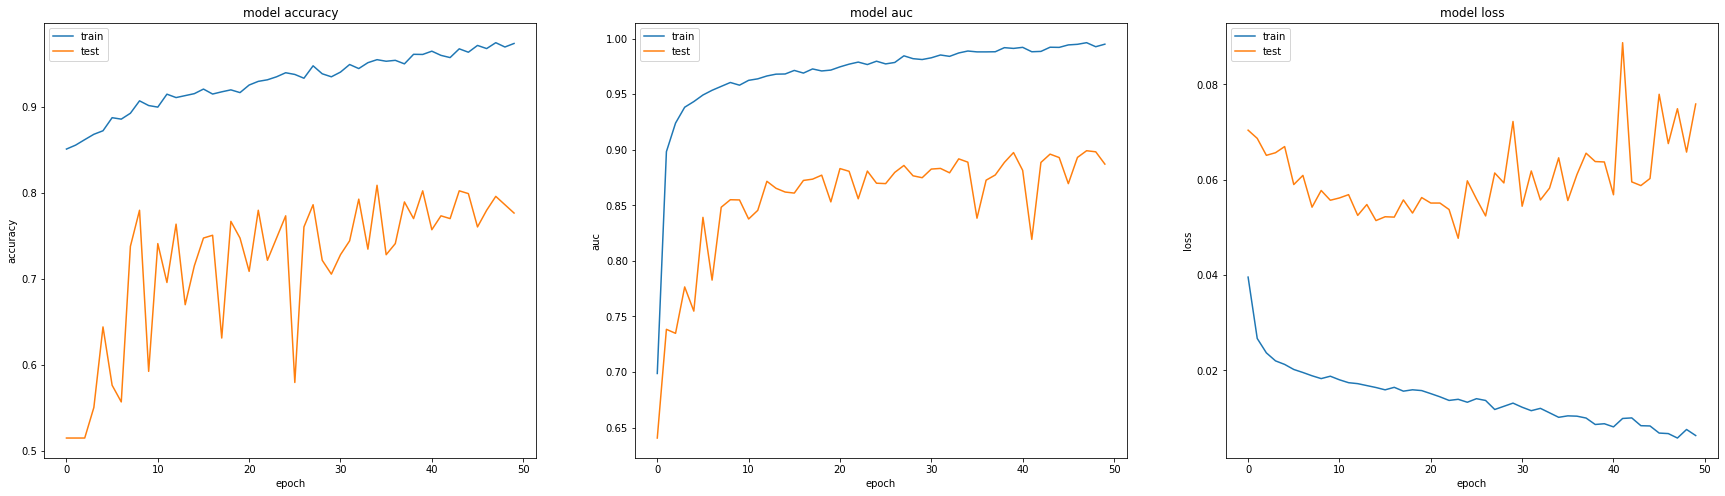

In [23]:
# summarize history for accuracy
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for auc
ax[1].plot(history.history['auc'])
ax[1].plot(history.history['val_auc'])
ax[1].set_title('model auc')
ax[1].set_ylabel('auc')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[2].plot(history.history['loss'])
ax[2].plot(history.history['val_loss'])
ax[2].set_title('model loss')
ax[2].set_ylabel('loss')
ax[2].set_xlabel('epoch')
ax[2].legend(['train', 'test'], loc='upper left')

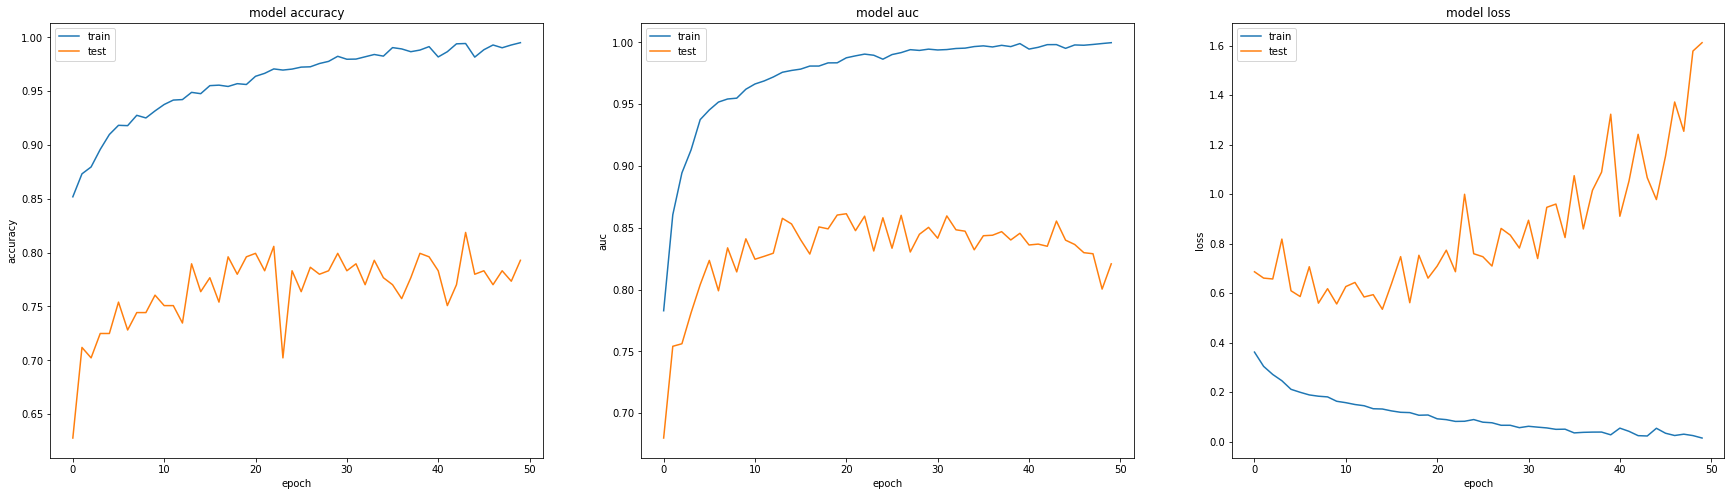

In [23]:
# summarize history for accuracy
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for auc
ax[1].plot(history.history['auc'])
ax[1].plot(history.history['val_auc'])
ax[1].set_title('model auc')
ax[1].set_ylabel('auc')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[2].plot(history.history['loss'])
ax[2].plot(history.history['val_loss'])
ax[2].set_title('model loss')
ax[2].set_ylabel('loss')
ax[2].set_xlabel('epoch')
ax[2].legend(['train', 'test'], loc='upper left')

#### **Results**
Submissions are evaluated on the area under the Receiver Operating Characteristic Curve ([ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))   
on the predicted probabilities, as calculated by [roc_auc_score in scikit-learn (v 0.23.1)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).


In [22]:
# !rm -rf ~/.nv/

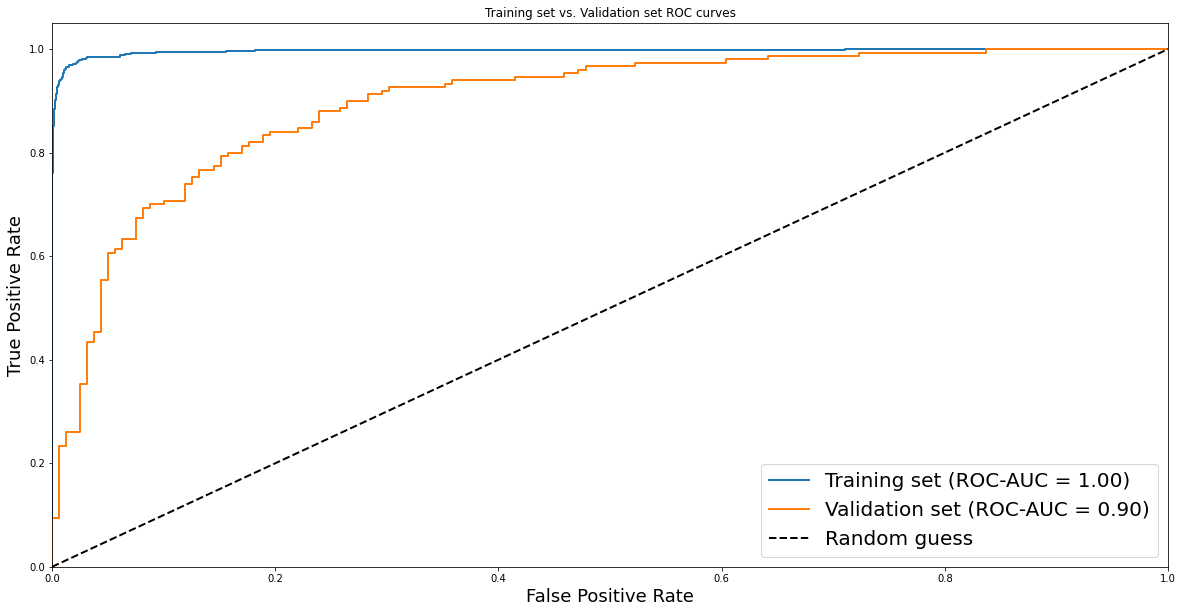

In [23]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [model.predict(train_x), model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)

## **Final Submission File**

Create a CSV submission file , zip and download it.

In [24]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)